Start by processing raw optical images of arrays


--- Processing Array_3Crop.bmp ---


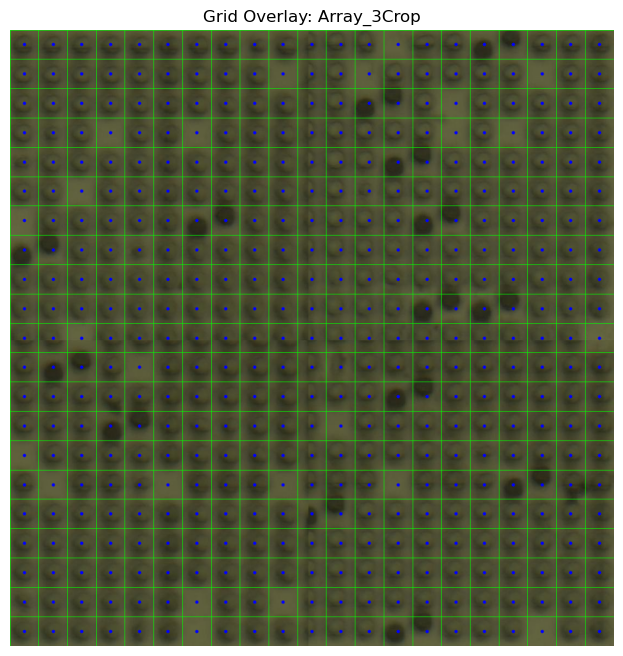

✓ Saved 441 tiles to Meta_Atoms\Array_3Crop

--- Processing Array_1Crop.bmp ---


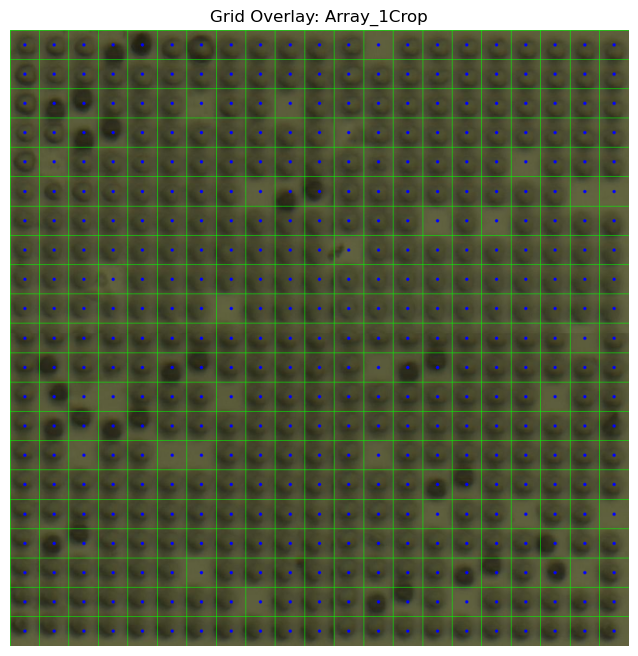

✓ Saved 441 tiles to Meta_Atoms\Array_1Crop

--- Processing Array_2Crop.bmp ---


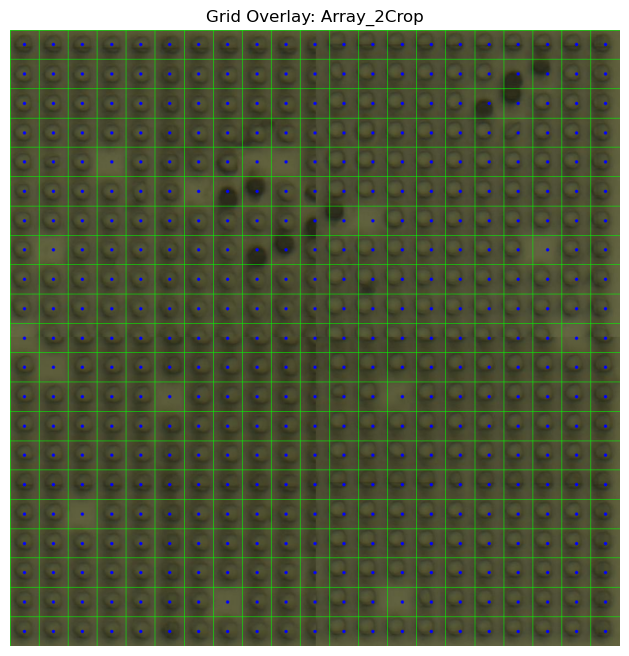

✓ Saved 441 tiles to Meta_Atoms\Array_2Crop


In [15]:
from array_segmentation import save_grid_images_simple
arrays={"Array_1Crop.bmp","Array_2Crop.bmp","Array_3Crop.bmp"}




output_dir = "Meta_Atoms"

for arr in arrays:
    print(f"\n--- Processing {arr} ---")
    save_grid_images_simple(
        image_path=arr,
        output_dir=output_dir,
        grid_size=21,
        tile_size=32,
        show_grid=True
    )



Missing pillar count per array:



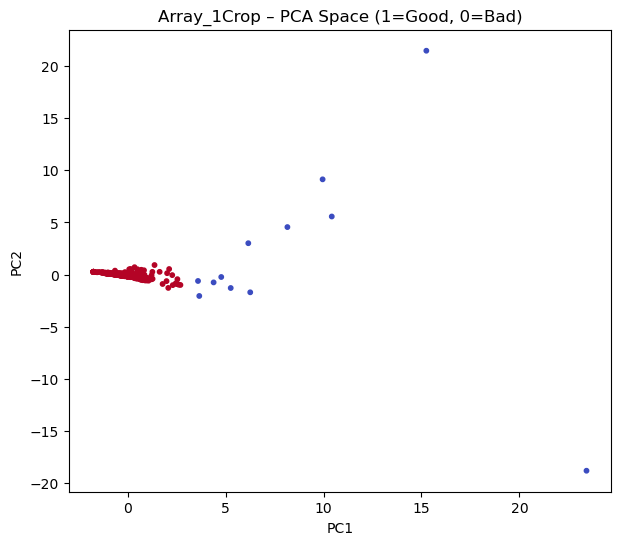

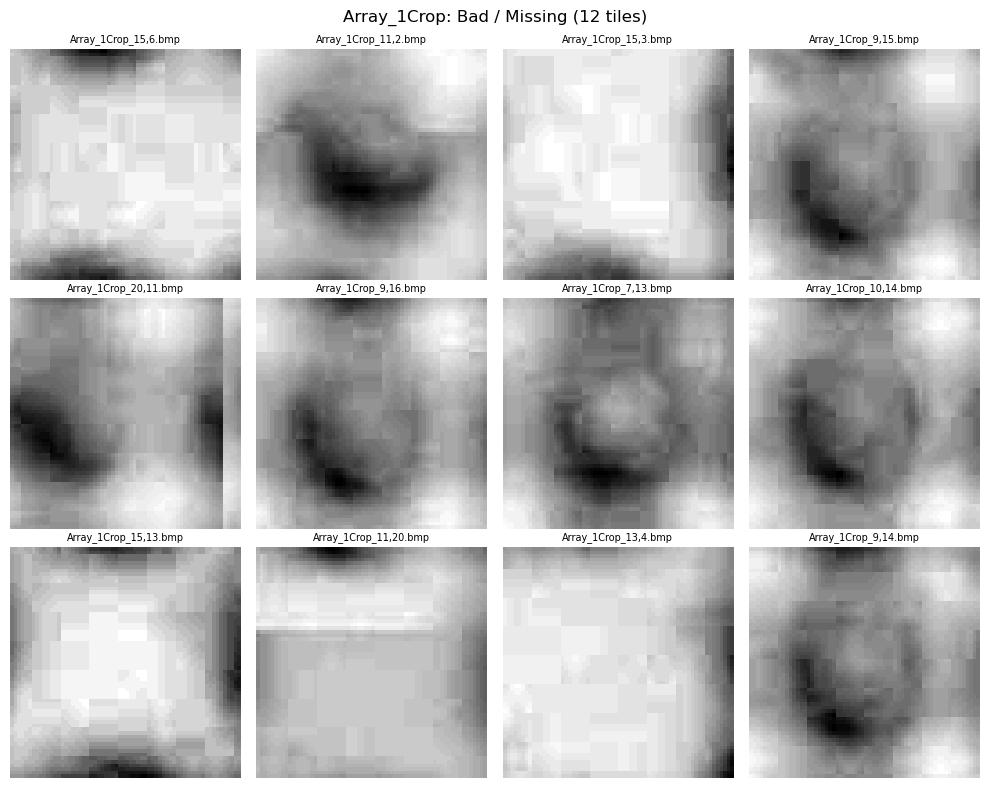

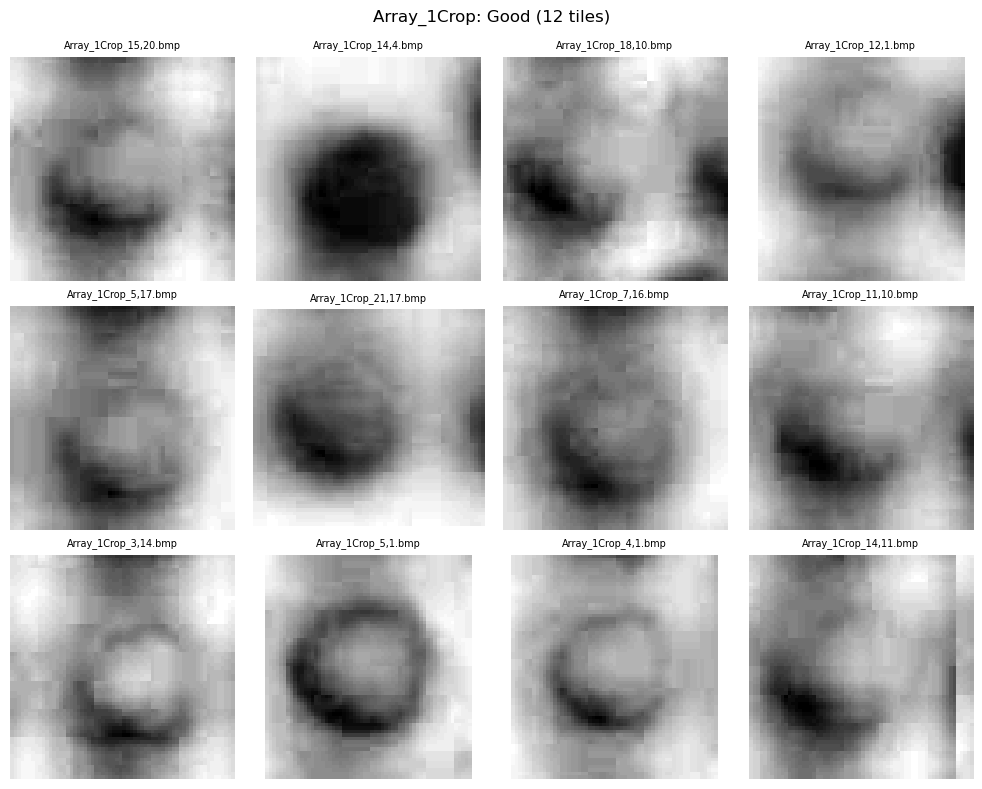

Array_1Crop: 12 missing


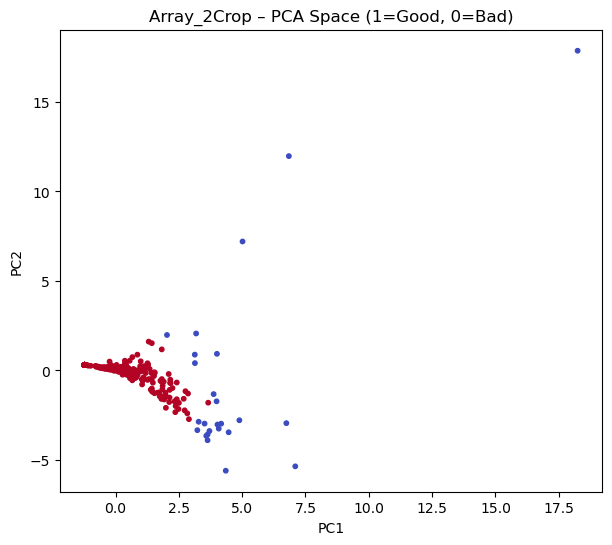

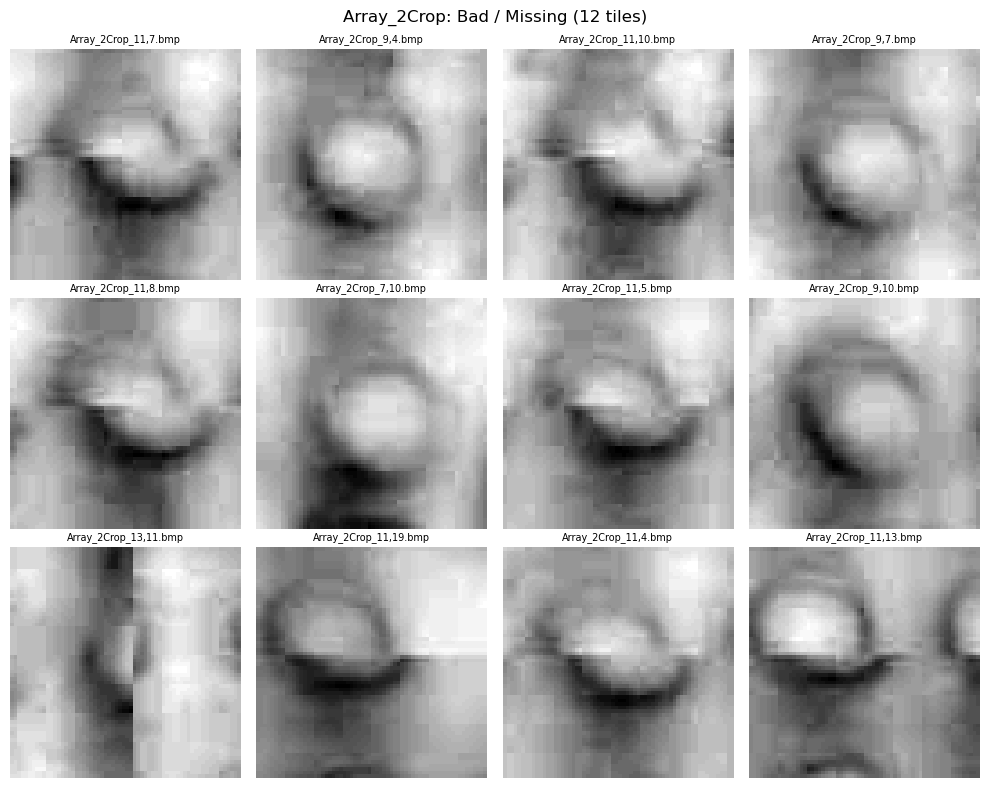

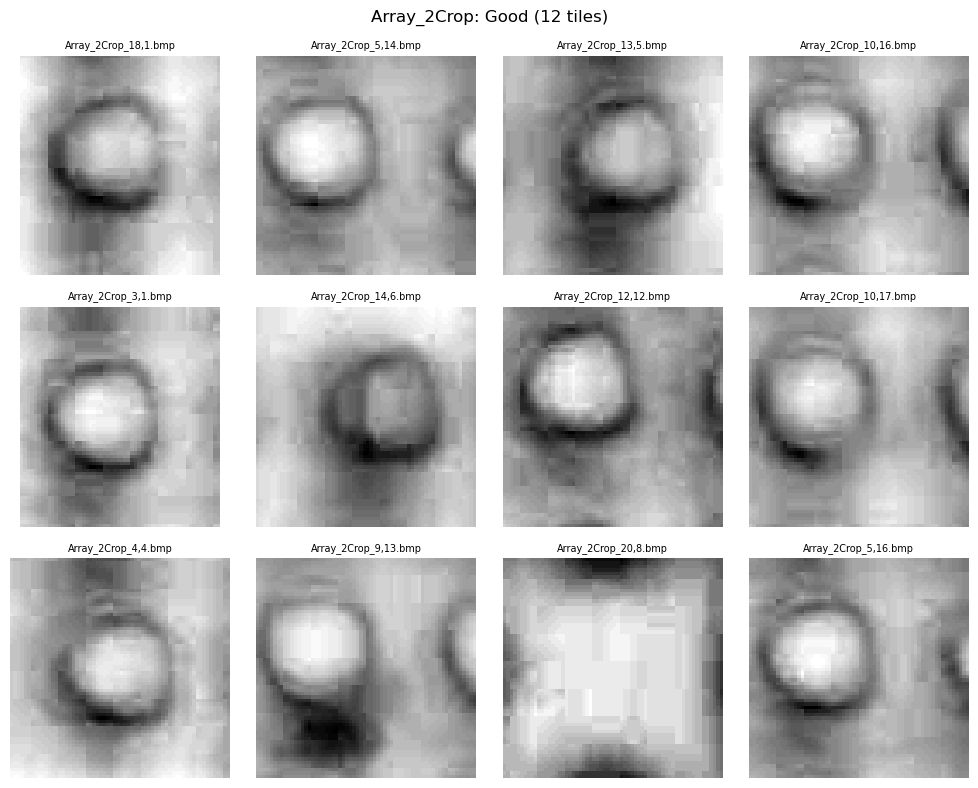

Array_2Crop: 25 missing


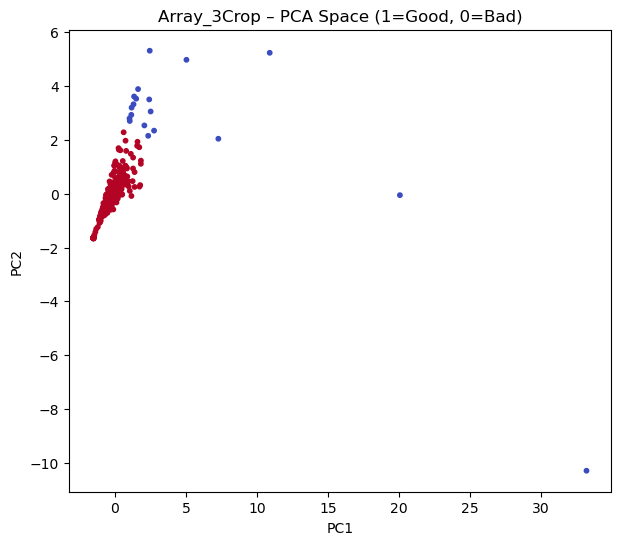

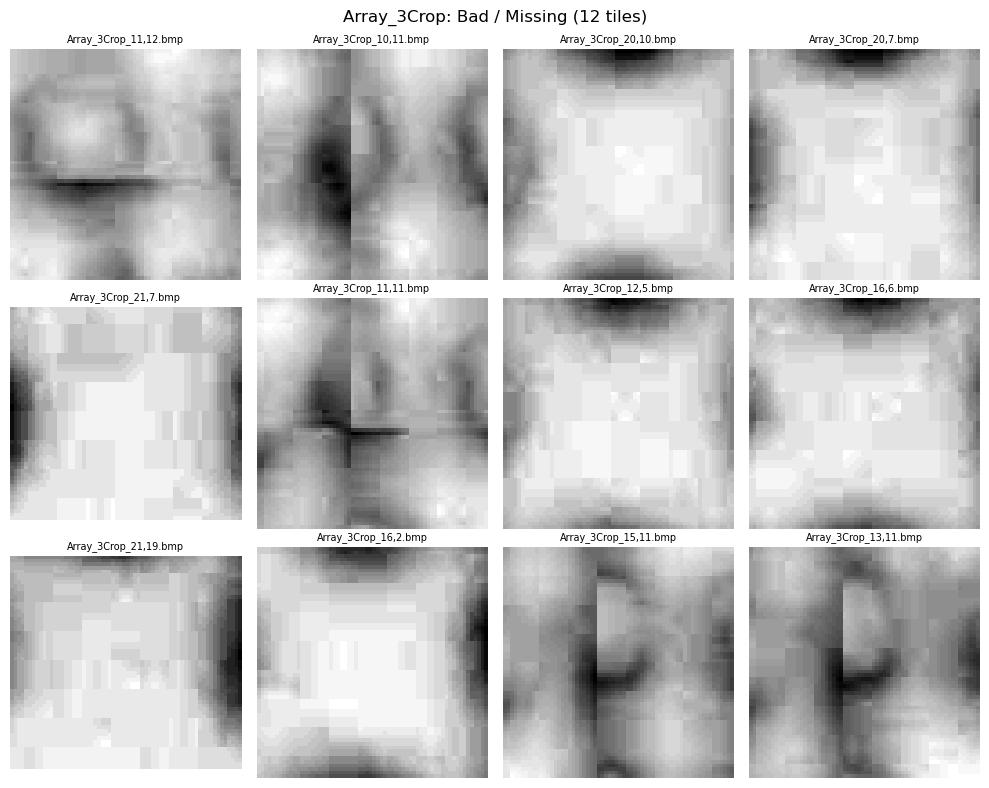

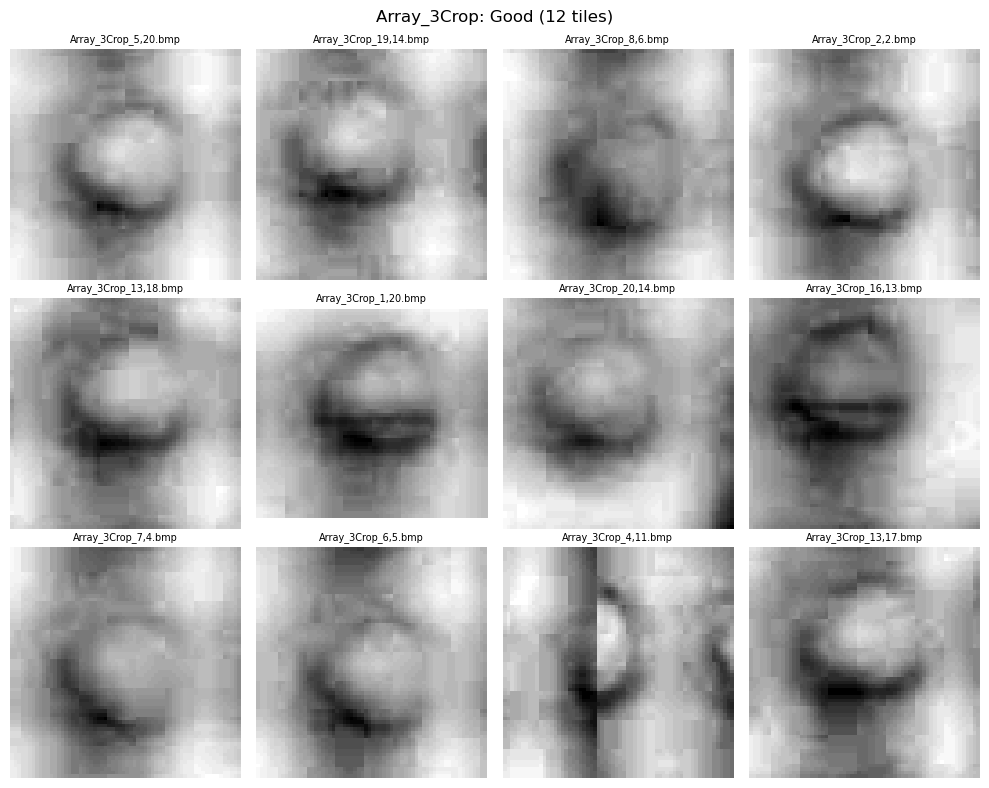

Array_3Crop: 19 missing


{'Array_1Crop': np.int64(12),
 'Array_2Crop': np.int64(25),
 'Array_3Crop': np.int64(19)}

In [2]:
from pathlib import Path
from Meta_Atom_Missing_Filter import count_missing

output_dir = Path("Meta_Atoms")
arrays = sorted([d for d in output_dir.iterdir() if d.is_dir()])

print("\nMissing pillar count per array:\n")
missing_counts = {}

for arr in arrays:
    n_missing = count_missing(arr, eps=1, min_samples=20, visualize=True)
    missing_counts[arr.name] = n_missing
    print(f"{arr.name}: {n_missing} missing")

missing_counts



Processing Array_1
Loaded 400 meta-atoms

Hu Moments Statistics:
  Shape: (400, 7)
  Mean: [ 2.91298248  7.53260582  9.76100785  9.69649505 -2.65       -4.74991881
  3.9       ]
  Std: [0.09853797 0.55437092 0.24993214 0.23566847 9.64248412 8.79976939
 9.20814856]

Clustering Results:
  Cluster 0: 258 atoms (64.5%)
  Cluster 1: 142 atoms (35.5%)


C:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


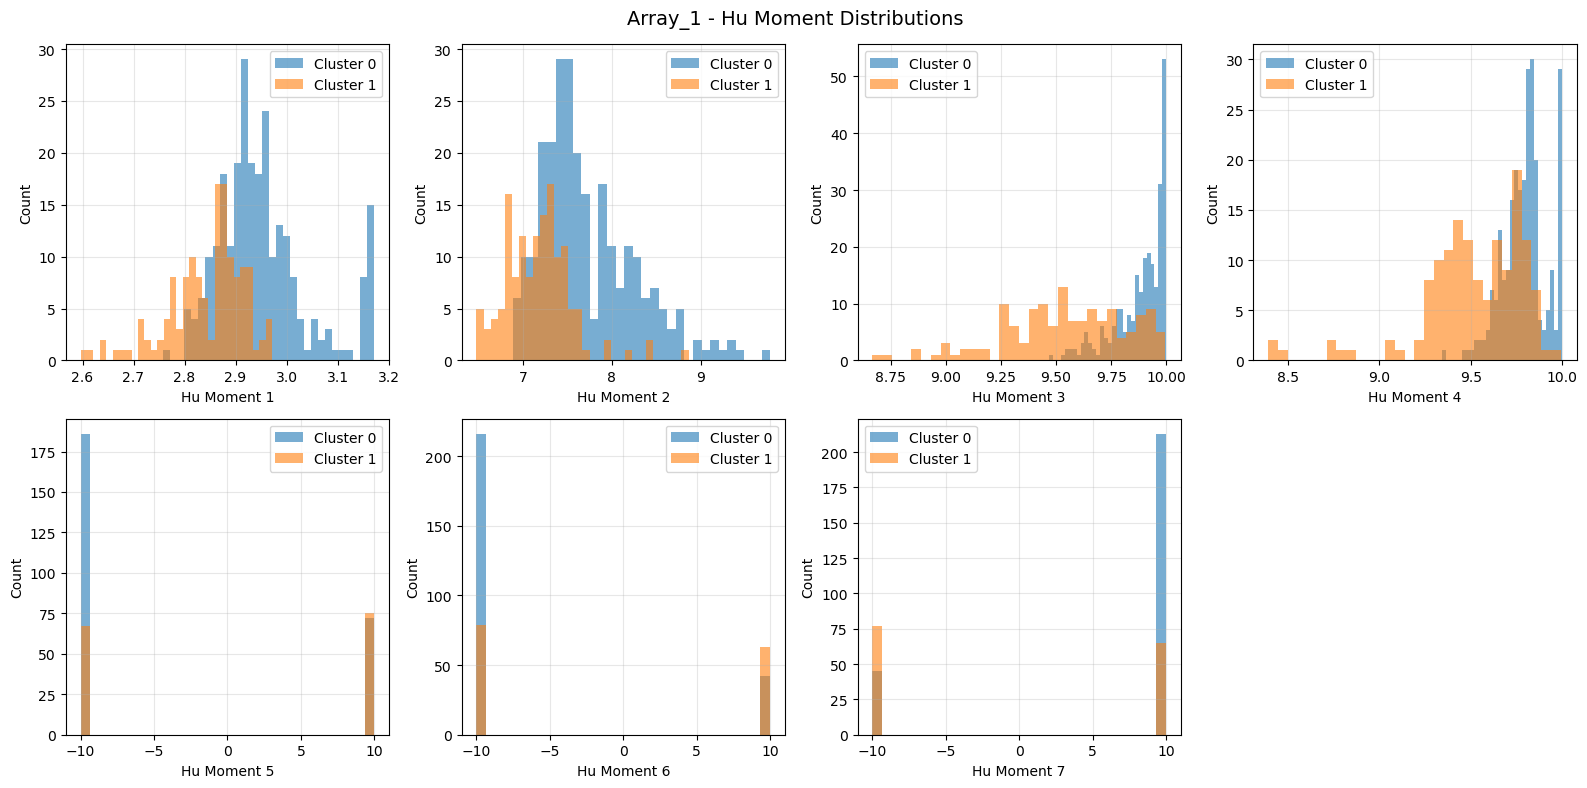

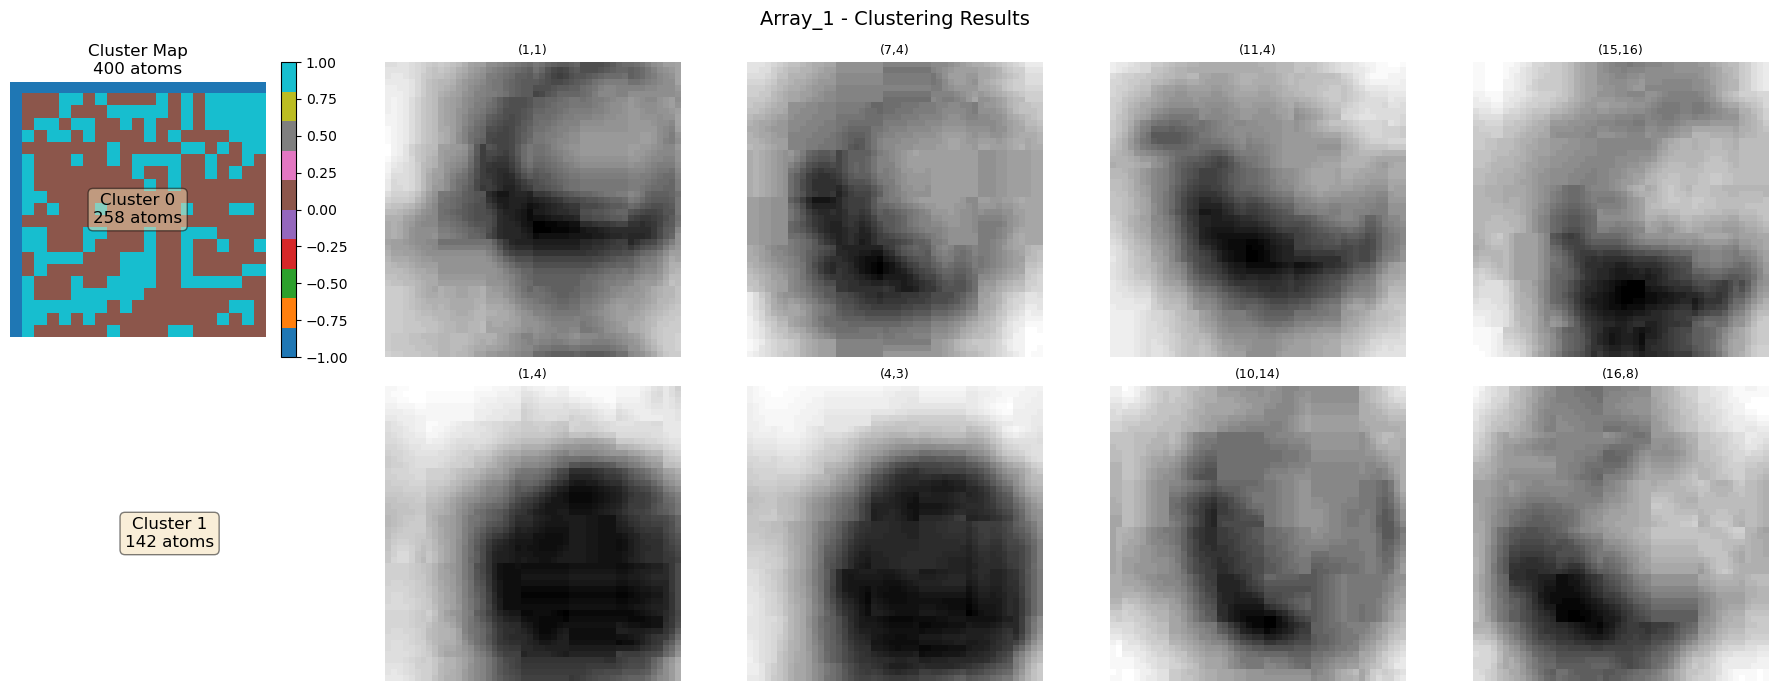

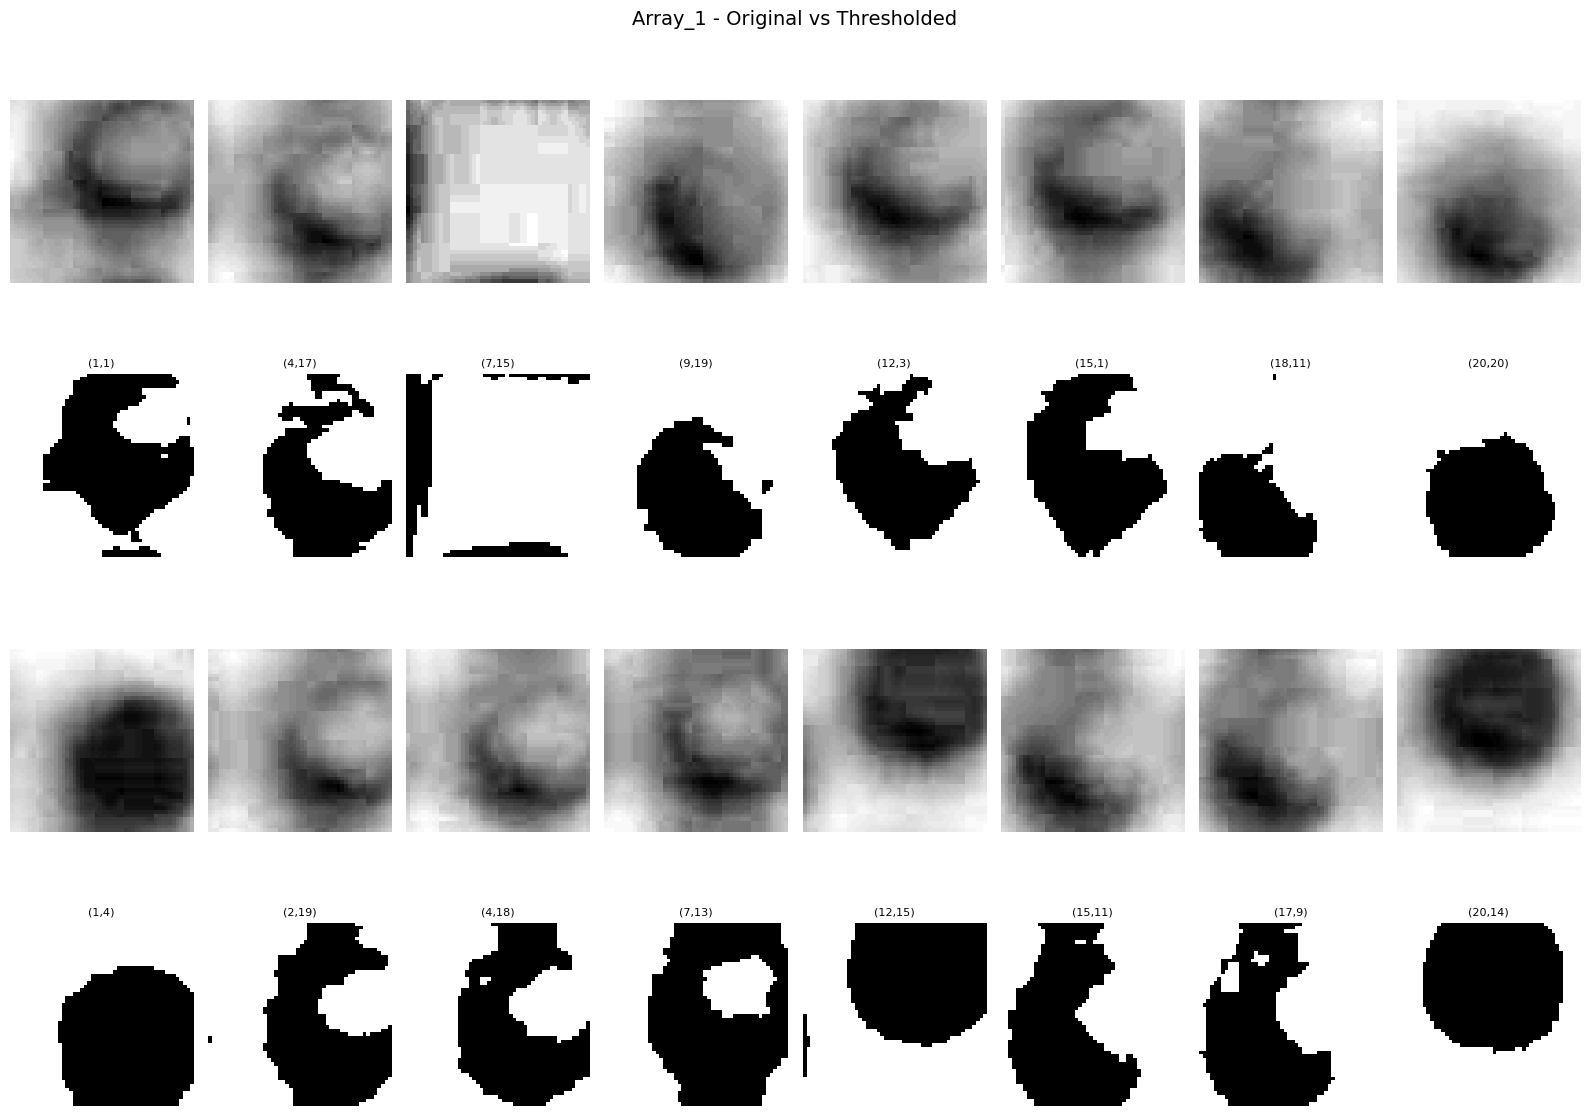

In [13]:
"""
Meta-Atom Clustering - Layer 1: Missing vs Present Pillars
Uses Hu Moments from contour detection
"""

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Config
OUTPUT_DIR = output_dir  # Change to your path
ARRAYS = [f"Array_{i}" for i in range(1, 11)]
GRID_SIZE = (21, 21)

def load_metaatom(array_name, row, col):
    """Load single meta-atom image"""
    filepath = Path(OUTPUT_DIR) / array_name / f"{array_name}_{row},{col}.bmp"
    if filepath.exists():
        img = cv2.imread(str(filepath), cv2.IMREAD_GRAYSCALE)
        return img
    return None

def extract_hu_moments(image):
    """Extract Hu moments from image"""
    if image is None:
        return None, None
    
    # Threshold image
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Calculate moments
    moments = cv2.moments(binary)
    
    # Calculate Hu moments
    hu_moments = cv2.HuMoments(moments)
    
    # Log transform to make them more manageable
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
    
    return hu_moments.flatten(), binary

def load_array_data(array_name):
    """Load all meta-atoms from an array"""
    images = []
    features = []
    binary_images = []
    positions = []
    
    for row in range(GRID_SIZE[0]):
        for col in range(GRID_SIZE[1]):
            img = load_metaatom(array_name, row, col)
            if img is not None:
                hu, binary = extract_hu_moments(img)
                if hu is not None:
                    images.append(img)
                    features.append(hu)
                    binary_images.append(binary)
                    positions.append((row, col))
    
    return np.array(images), np.array(features), binary_images, positions

def cluster_kmeans(features, n_clusters=2):
    """KMeans clustering"""
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_scaled)
    return labels

def plot_hu_moment_distributions(features, labels, array_name):
    """Plot Hu moment distributions for each cluster"""
    unique_labels = sorted(np.unique(labels))
    n_moments = features.shape[1]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f'{array_name} - Hu Moment Distributions', fontsize=14)
    axes = axes.flatten()
    
    for i in range(n_moments):
        ax = axes[i]
        for label in unique_labels:
            cluster_data = features[labels == label, i]
            ax.hist(cluster_data, bins=30, alpha=0.6, label=f'Cluster {label}')
        
        ax.set_xlabel(f'Hu Moment {i+1}')
        ax.set_ylabel('Count')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Remove extra subplot
    axes[-1].axis('off')
    
    plt.tight_layout()
    return fig

def visualize_results(array_name, images, binary_images, labels, positions):
    """Show clustering results"""
    unique_labels = sorted(np.unique(labels))
    
    # Create cluster grid
    grid = np.full(GRID_SIZE, -1, dtype=int)
    for idx, (row, col) in enumerate(positions):
        grid[row, col] = labels[idx]
    
    fig, axes = plt.subplots(2, 5, figsize=(18, 7))
    fig.suptitle(f'{array_name} - Clustering Results', fontsize=14)
    
    # Show cluster map
    im = axes[0, 0].imshow(grid, cmap='tab10', interpolation='nearest')
    axes[0, 0].set_title(f'Cluster Map\n{len(positions)} atoms')
    axes[0, 0].axis('off')
    plt.colorbar(im, ax=axes[0, 0])
    
    # Show examples from each cluster
    for cluster_idx, label in enumerate(unique_labels):
        cluster_indices = np.where(labels == label)[0]
        n_atoms = len(cluster_indices)
        
        # Show 4 examples per cluster
        for ex_idx in range(4):
            ax_row = cluster_idx
            ax_col = ex_idx + 1
            
            if ex_idx < len(cluster_indices):
                idx = cluster_indices[ex_idx * len(cluster_indices) // 4]
                axes[ax_row, ax_col].imshow(images[idx], cmap='gray')
                row, col = positions[idx]
                axes[ax_row, ax_col].set_title(f'({row},{col})', fontsize=9)
            axes[ax_row, ax_col].axis('off')
        
        axes[ax_row, 0].text(0.5, 0.5, f'Cluster {label}\n{n_atoms} atoms', 
                            ha='center', va='center', fontsize=12, 
                            transform=axes[ax_row, 0].transAxes,
                            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[ax_row, 0].axis('off')
    
    plt.tight_layout()
    return fig

def show_binary_examples(array_name, images, binary_images, labels, positions, n_examples=8):
    """Show original and thresholded images"""
    unique_labels = sorted(np.unique(labels))
    
    fig, axes = plt.subplots(len(unique_labels) * 2, n_examples, 
                            figsize=(16, 3 * len(unique_labels) * 2))
    fig.suptitle(f'{array_name} - Original vs Thresholded', fontsize=14)
    
    for cluster_idx, label in enumerate(unique_labels):
        cluster_indices = np.where(labels == label)[0]
        n_show = min(n_examples, len(cluster_indices))
        
        # Show evenly spaced examples
        example_indices = cluster_indices[np.linspace(0, len(cluster_indices)-1, n_show, dtype=int)]
        
        for ex_idx, img_idx in enumerate(example_indices):
            # Original image
            axes[cluster_idx * 2, ex_idx].imshow(images[img_idx], cmap='gray')
            axes[cluster_idx * 2, ex_idx].axis('off')
            if ex_idx == 0:
                axes[cluster_idx * 2, ex_idx].set_ylabel(f'C{label}\nOriginal', fontsize=10)
            
            # Binary image
            axes[cluster_idx * 2 + 1, ex_idx].imshow(binary_images[img_idx], cmap='gray')
            row, col = positions[img_idx]
            axes[cluster_idx * 2 + 1, ex_idx].set_title(f'({row},{col})', fontsize=8)
            axes[cluster_idx * 2 + 1, ex_idx].axis('off')
            if ex_idx == 0:
                axes[cluster_idx * 2 + 1, ex_idx].set_ylabel(f'C{label}\nBinary', fontsize=10)
        
        # Clear unused subplots
        for ex_idx in range(n_show, n_examples):
            axes[cluster_idx * 2, ex_idx].axis('off')
            axes[cluster_idx * 2 + 1, ex_idx].axis('off')
    
    plt.tight_layout()
    return fig

def analyze_array(array_name):
    """Complete analysis for one array"""
    print(f"\n{'='*60}")
    print(f"Processing {array_name}")
    print(f"{'='*60}")
    
    # Load data
    images, features, binary_images, positions = load_array_data(array_name)
    print(f"Loaded {len(images)} meta-atoms")
    
    # Show Hu moment stats
    print(f"\nHu Moments Statistics:")
    print(f"  Shape: {features.shape}")
    print(f"  Mean: {np.mean(features, axis=0)}")
    print(f"  Std: {np.std(features, axis=0)}")
    
    # Cluster
    labels = cluster_kmeans(features, n_clusters=2)
    
    # Print cluster stats
    unique_labels = sorted(np.unique(labels))
    print(f"\nClustering Results:")
    for label in unique_labels:
        count = np.sum(labels == label)
        print(f"  Cluster {label}: {count} atoms ({100*count/len(labels):.1f}%)")
    
    # Visualize
    fig1 = plot_hu_moment_distributions(features, labels, array_name)
    fig2 = visualize_results(array_name, images, binary_images, labels, positions)
    fig3 = show_binary_examples(array_name, images, binary_images, labels, positions, n_examples=8)
    
    plt.show()
    
    return {
        'images': images,
        'features': features,
        'binary_images': binary_images,
        'positions': positions,
        'labels': labels
    }

# Run analysis
if __name__ == "__main__":
    # Test with first array
    results = analyze_array("Array_1")
    
    # Uncomment to process all arrays
    # for array_name in ARRAYS:
    #     try:
    #         results = analyze_array(array_name)
    #     except Exception as e:
    #         print(f"Error processing {array_name}: {e}")